# k-means clustering using MNIST images
**_Jake Daly_** | **_ECE 174_**

Although a relatively simple algorithm in the domain of unsupervised learning, k-means clustering provides a powerful heuristic for understanding the spread of data in a set. In this programming assignment, we will apply the k-means clustering algorithm to a well-known data set, the set of MNIST hand-written numbers, which are 28x28 pixel images. The data are converted from their 28x28 pixel 2-D representations into a more abstract 784-vector representation, so that we can more easily work with the data in the algorithm. 

We will begin by importing some relevant packages, namely <code>numpy</code>, <code>gzip</code> and <code>matplotlib</code>, to help us import the MNIST data set, as well as visualize an example of what one of these numbers looks like.



In [ ]:
import numpy as np
import gzip
import matplotlib.pyplot as plt


#import help from https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python
f = gzip.open('train-images-idx3-ubyte.gz','r') #unzip the data set which was compressed into a gzip file on the local drive

image_size = 28 #size (in one dimension) of the images to be clustered
num_images = 60000 #number of images that we will cluster

f.read(16)
buf = f.read(image_size*image_size*num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)

image = np.asarray(data[2]).squeeze()
plt.imshow(image)
plt.show()

## Interpretation of data

Granted that these MNIST numbers (or any number for that matter) are written with legible enough handwriting, it's a completely trivial task for the human brain to cluster the data. For example, if a human were given 100 random photos from this set and told that each photo belonged to one of K = 10 clusters, he or she could instantly categorize them into one of the ten clusters, with each cluster representing one of the ten digits.

Things are not this clear-cut in the high-dimensional vector spaces that algorithms and computers operate in. 

For example while it might be easy to see the above number is a 4 when visualized with the help of <code>pyplot</code>, when we look at this image represented as a 28x28 matrix of pixel values, this is not at all clear. It becomes even less clear when we convert this 2D matrix to a vector! Below we will print what this "4" looks like as a matrix:

In [ ]:
print(np.shape(data))
print(np.shape(data)[0])
print(data[0,:,:,0])

## New representation of data

High-dimensional data is often not visualizable, but the beauty of the algorithms with which we operate on these vectors is that their mathematical underpinnings are still valid. Below we will rearrange the data into vectors of length 784, so that we can perform the 1D computations on them that the k-means algorithm requires. 

In [ ]:
# Rearrange data from 28x28 matrices to length 784 vectors.
data_list = []
for im in range(np.shape(data)[0]):
    element = data[im,:,:,0].reshape((784)) #reshape each 2D image as a 1D vector with the same number of elements
    data_list.append(element) #append this 1D image vector to our list of data vectors

#Print the new representation of our images
print("New representation of data:")
print("Num images: %s | Length of each image: %s"%(np.shape(data_list)[0], np.shape(data_list)[1]))




## The k-means algorithm

Below we will define our k-means algorithm, which takes as inputs a list of vectors (our images of numbers represented in 1D), along with a number of groups to cluster them in. The algorithm will perform some book keeping such as the recasting of data as <code>numpy</code> arrays, and allocation of internal variables. The group representatives have been intialized as *K* random vectors from the data_list, as these will (in general) provide starting points for the group representatives which will be closer to their final positions than if we had just initialized everything to zero. This is because we are essentially intializing each group representative to a random hand-written number (represented as a vector), and these vectors will be closer to the final value (which is an an average of all the numbers in that group), as opposed to if we intialized all to zero.

After initialization, the algorithm will enter a while loop, which will loop through the algorithm a fixed number of times, iteratively computing the closest group representatives for each vector, and then updating the group representatives to be the average (mean) of all the vectors in that group. Specifically, we will loop through each data vector, and check which group representative it is closest to. We will also keep track of the distance of this data vector from the group representative it's closest to, so that we can later on compute how much total error there is between every vector and its representative. After we determine which vectors belong to which groups, we compute the centroid of that cluster by computing the mean of all the vectors in that group, and using this value to update the group representative. 

After that, we compute the sum of the errors of each vector from it's *new* group grepresentative, and save this in a vector J_clust, so that we can see our error improving on each iteration. Once the group assignments have stopped changing from one iteration to the next, we will stop the algorithm because even if we could get incremental improvements of the values of the group representatives, the group's members have converged to their final state.

In [ ]:
def kmeans(data_list, K):
    
    #Convert list to numpy array so we can perform numpy operations on it
    data_list = np.array(data_list)
    
    #Allocate lists for group representative variables and 
    group_representatives = []
    new_group_reps = []
    J_clust = []
    closest_reps_old = [0]*np.shape(data_list)[0]
    
    # initialize k group representatives
    for i in range(K):
        random_index = np.random.randint(low=0, high=len(data_list))
        new_group_reps.append(data_list[random_index])
    
    keep_going = True
    while(keep_going):
        distances_to_reps = [[] for i in range(K)]
        sum_distances_jth_clust = [0]*K
        group_representatives = new_group_reps
        
        #assign each vector to the nearest group representative
        closest_reps = []
        groups_vecs = [[] for k in range(K)]
        for vec_index in range(np.shape(data_list)[0]):
            distances = [np.linalg.norm(data_list[vec_index] - grp_rep) for grp_rep in group_representatives]
            closest_rep = np.argmin(distances)
            closest_distance = distances[closest_rep]
            distances_to_reps[closest_rep].append([vec_index, closest_distance])
            sum_distances_jth_clust[closest_rep] += distances[closest_rep]
            groups_vecs[closest_rep].append(data_list[vec_index])
            closest_reps.append(closest_rep)

        #update each group representative to be the centroid of it's vectors
        for i in range(len(groups_vecs)):

            group = np.array(groups_vecs[i])

            average = 0
            for j in range(np.shape(group)[0]):
                average += group[j,:]/np.shape(group)[0]
                
            new_group_reps[i] = average

        #compute updated Jclust
        sum_distances_to_new_rep = [0]*K
        for vec_index in range(len(data_list)):

            sum_distances_to_new_rep[closest_reps[vec_index]] += np.linalg.norm(data_list[vec_index] - new_group_reps[closest_reps[vec_index]])
        
        j_clust = np.sum(sum_distances_to_new_rep)
        J_clust.append(j_clust)
        
        number_reps_the_same = [i for i, j in zip(closest_reps, closest_reps_old) if i == j]

        if (len(number_reps_the_same)) == np.shape(data_list)[0]: # > int(.95*np.shape(data_list)[0]):
            keep_going = False
            
        else:
            keeping_going = True
            print("Convergence: %s group assignments out of %s"%(len(number_reps_the_same),np.shape(data_list)[0]))
            closest_reps_old = closest_reps
    
    return {"group_assignments": closest_reps, "group_representatives": new_group_reps, "J_clust": J_clust, "distances_to_reps": distances_to_reps}

def find_closest_10(distances_to_reps):
    
    sorted_distances = np.ndarray((len(distances_to_reps),10))
    
    for gr in range(len(distances_to_reps)):

        temp = np.array(distances_to_reps[gr])
        temp = temp[temp[:,1].argsort()]
        sorted_distances[gr, :] = temp[0:10,0]
    
    return sorted_distances
    
    

# k-means(data, K=20) for 30 iterations

We will now run the algorithm with 20 different groups, repeating for thirty iterations. Each iteration of the algorithm will have different convergences due to the different intialization of it's group representatives. Each iteration will terminate, as mentioned previously, when the group assignments for each data vector have stopped changing from one iteration to the next. 

In [ ]:
out_data_master_2030 = []

for run in range(30):
    print("\n\n\n~~~~~~~~~~~~~~~Run number: %s~~~~~~~~~~~~~~~\n\n\n"%run)
    out_data = kmeans(data_list, 20)
    J_clust = out_data["J_clust"][-1]
    if run == 0:
        min_J_clust = {"Run": 0, "min_value": J_clust}
        max_J_clust = {"Run": 0, "max_value": J_clust}
    else:
        if J_clust > max_J_clust["max_value"]:
            max_J_clust["Run"] = run
            max_J_clust["max_value"] = J_clust
        
        if J_clust < min_J_clust["min_value"]:
            min_J_clust["Run"] = run
            min_J_clust["min_value"] = J_clust
                
    out_data_master_2030.append(out_data)

    

    

### Plot max and min J_clust runs

Performing 30 iterations of the algorithm for K = 20 groups, we observe decent fidelity of various digits represented by the group representatives.
- How do max and min compare?
- Do they converge to roughly the same value?
- Are any of the group representatives ambiguous which numbers they represent?


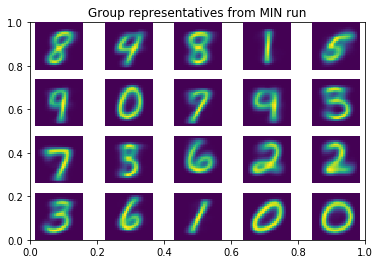

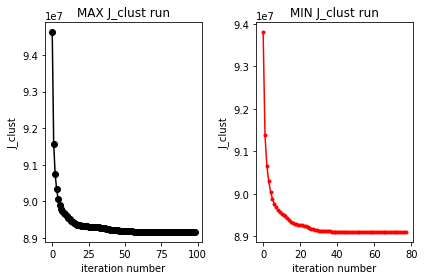

In [47]:
# Plot the min and max J_clust runs

MAX_run = out_data_master_2030[max_J_clust["Run"]]
MIN_run = out_data_master_2030[min_J_clust["Run"]]


fig1 = plt.figure()
plt.title('Group representatives from MIN run')

for i in range(np.shape(MIN_run["group_representatives"])[0]):
    
    image = np.array(MIN_run["group_representatives"])[i].reshape((28,28))
    sub = fig1.add_subplot(4, 5, i + 1)
    plt.axis('off')
    sub.imshow(image)

fig2 = plt.figure()
plt.title('Group representatives from MAX run')

for i in range(np.shape(MAX_run["group_representatives"])[0]):
    image = np.array(MAX_run["group_representatives"])[i].reshape((28,28))
    sub = fig2.add_subplot(4, 5, i + 1)
    plt.axis('off')
    sub.imshow(image)

# Convergence of J_clust in MAX and MIN runs
plt.subplot(1, 2, 1)
plt.plot(MAX_run["J_clust"], 'ko-')
plt.title('MAX J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')


plt.subplot(1, 2, 2)
plt.plot(MIN_run["J_clust"], 'r.-')
plt.title('MIN J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')

plt.tight_layout()

plt.show()

To see how accurate our results are, we can look at the ten closest data vectors (images) to the group representatives. If most of these ten closest data vectors resemble the number that the group representative resembles, then we can reasonably assume

In [ ]:
# Print the closest ten data vectors to the group representatives of the max and min runs:
closest_10_for_each_grouprep_MAX = find_closest_10(MAX_run["distances_to_reps"])
closest_10_for_each_grouprep_MIN = find_closest_10(MIN_run["distances_to_reps"])

# print(np.shape(MAX_run["distances_to_reps"]))
# print(np.shape(closest_10_for_each_grouprep_MAX)[0])

for index in range(np.shape(closest_10_for_each_grouprep_MAX)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MAX run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MAX)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MAX[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

for index in range(np.shape(closest_10_for_each_grouprep_MIN)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MIN run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MIN)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MIN[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)



## Statistics for K = 20, 30 iterations

To gauge how well our algorithm was able to cluster numbers, we can look at the 10 closest (as measured by Euclidian norm) images to each group representative on the run where we had the highest final $J_{clust}$ (most amount of error) and smallest final $J_{clust}$ (least amount of error). When we look at the image above of the 20 group representatives from the max run for example, the very first one resembles a 6. We can plot the 10 closest points to this one, and indeed, all ten closest points are 6's!:

![title](img/2030/max0-3-0errors.png)

Although this is what we'd expect with each group representative, this is not guarunteed to be the case. In fact, if we look at the ten closest points to a couple of the other group representatives, we can see some of these images are not the same identifiable number that the group representative is. Looking at the 8th group representative in the plot, it most closely looks like a 3, but when we plot the 10 closest neighbors, we see that 4 of 10 are actually images of 8's:

![title](img/2030/max8-3-4errors.png)

For the max run where the $J_{clust}$ error was the highest, there occurred an extreme case where three different digits were represented in the 10 samples closest to the group representative:

![title](img/2030/max5-5-4errors.png)

It's not completely clear looking at these ten photos which number the group representative is actually supposed to be representing. What this means in terms of our algorithm is that as this group representative was being updated on each iteration, it found a local minima in the error (distance) to members in it's cluster; once it converged to this minima (which spatially was in between several different groups of *actual* numbers, the closest data points latched onto it. Because they stopped changing groups, the algorithm eventually terminated as this was the end case. 

One way we can try to quantify the accuracy of the max run is by taking the number of correct classifications of digits out of the ones we've chosen to observe (the ten closest to each of twenty group representatives). Although this method is subject to human opinion (i.e., I am the one decided what number a group representative most closely resembles), it will still give us *some* metric as to how well the algorithm worked. **_For the "max" $J_{clust}$ run, the algorithm correctly classified 181/200 (90.5%) images_** From tallying up instances where one of the ten closest numbers was not the same as digit depicted by the group representative, it is clear that the algorithm struggled mostly distinguishing between 4s and 9s, and between 5s and 3s.

We can apply these same methods to the run with the minimum $J_{clust}$. Whereas the final value of $J_{clust}$ for the max run was about 89,368,067.20, this same value for the minimum run was 88,858,587.64. If we tally up the total number of "wrong" classifications from the minimum run, we obtain 14 misclassifications. **_This means that for the min $J_{clust}$ run, it correctly classified 186/200 (93%) images, or a ~2.5% improvement of the max run!_**


# k-means(data, K=10) for 20 iterations

In [ ]:
out_data_master_1020 = []

for run in range(20):
    print("\n\n\n~~~~~~~~~~~~~~~Run number: %s~~~~~~~~~~~~~~~\n\n\n"%run)
    out_data = kmeans(data_list, 10)
    J_clust = out_data["J_clust"][-1]
    if run == 0:
        min_J_clust = {"Run": 0, "min_value": J_clust}
        max_J_clust = {"Run": 0, "max_value": J_clust}
    else:
        if J_clust > max_J_clust["max_value"]:
            max_J_clust["Run"] = run
            max_J_clust["max_value"] = J_clust
        
        if J_clust < min_J_clust["min_value"]:
            min_J_clust["Run"] = run
            min_J_clust["min_value"] = J_clust
                
    out_data_master_1020.append(out_data)



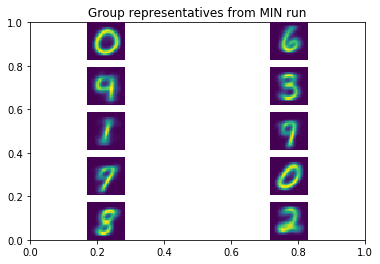

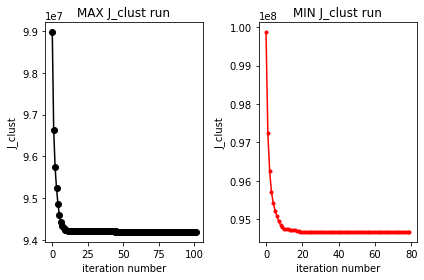

In [49]:
# Plot the min and max J_clust runs

MAX_run = out_data_master_1020[max_J_clust["Run"]]
MIN_run = out_data_master_1020[min_J_clust["Run"]]

fig = plt.figure()
plt.title('Group representatives from MIN run')

for i in range(np.shape(MIN_run["group_representatives"])[0]):
    
    image = np.array(MIN_run["group_representatives"])[i].reshape((28,28))
    sub = fig.add_subplot(5, 2, i + 1)
    plt.axis('off')
    sub.imshow(image)

fig = plt.figure()
plt.title('Group representatives from MAX run')

for i in range(np.shape(MAX_run["group_representatives"])[0]):
    
    image = np.array(MAX_run["group_representatives"])[i].reshape((28,28))
    sub = fig.add_subplot(5, 2, i + 1)
    plt.axis('off')
    sub.imshow(image)

# Convergence of J_clust in MAX and MIN runs
plt.subplot(1, 2, 1)
plt.plot(MAX_run["J_clust"], 'ko-')
plt.title('MAX J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')


plt.subplot(1, 2, 2)
plt.plot(MIN_run["J_clust"], 'r.-')
plt.title('MIN J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')

plt.tight_layout()

plt.show()

In [ ]:
# Print the closest ten data vectors to the group representatives of the max and min runs:
closest_10_for_each_grouprep_MAX = find_closest_10(MAX_run["distances_to_reps"])
closest_10_for_each_grouprep_MIN = find_closest_10(MIN_run["distances_to_reps"])

for index in range(np.shape(closest_10_for_each_grouprep_MAX)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MAX run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MAX)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MAX[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

for index in range(np.shape(closest_10_for_each_grouprep_MIN)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MIN run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MIN)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MIN[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

## Statistics for K = 10, 20 iterations

Computing similar statistics for as we did before, for K=10 with 20 iterations!

$J_{clust}$ from max run: 94185750.95806885

$J_{clust}$ from min run: 95048205.77789307

Number of correct guesses based off observing 10 closest data points:
min: 91/100 (91 %)
max: 89/100 (89 %)

Most frequently misclassified numbers:
4 and 9

# k-means(data, K=5) for 10 iterations

In [ ]:
out_data_master_0510 = []

for run in range(10):
    print("\n\n\n~~~~~~~~~~~~~~~Run number: %s~~~~~~~~~~~~~~~\n\n\n"%run)
    out_data = kmeans(data_list, 5)
    J_clust = out_data["J_clust"][-1]
    if run == 0:
        min_J_clust = {"Run": 0, "min_value": J_clust}
        max_J_clust = {"Run": 0, "max_value": J_clust}
    else:
        if J_clust > max_J_clust["max_value"]:
            max_J_clust["Run"] = run
            max_J_clust["max_value"] = J_clust
        
        if J_clust < min_J_clust["min_value"]:
            min_J_clust["Run"] = run
            min_J_clust["min_value"] = J_clust
                
    out_data_master_0510.append(out_data)



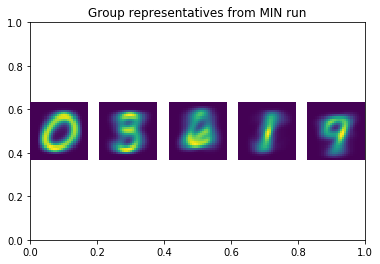

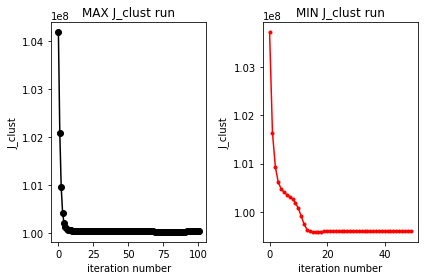

In [48]:
# Plot the min and max J_clust runs

MAX_run = out_data_master_0510[max_J_clust["Run"]]
MIN_run = out_data_master_0510[min_J_clust["Run"]]

fig = plt.figure()
plt.title('Group representatives from MIN run')

for i in range(np.shape(MIN_run["group_representatives"])[0]):
    
    image = np.array(MIN_run["group_representatives"])[i].reshape((28,28))
    sub = fig.add_subplot(1, 5, i + 1)
    plt.axis('off')
    sub.imshow(image)

fig = plt.figure()
plt.title('Group representatives from MAX run')

for i in range(np.shape(MAX_run["group_representatives"])[0]):
    
    image = np.array(MAX_run["group_representatives"])[i].reshape((28,28))
    sub = fig.add_subplot(1, 5, i + 1)
    plt.axis('off')
    sub.imshow(image)

# Convergence of J_clust in MAX and MIN runs
plt.subplot(1, 2, 1)
plt.plot(MAX_run["J_clust"], 'ko-')
plt.title('MAX J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')


plt.subplot(1, 2, 2)
plt.plot(MIN_run["J_clust"], 'r.-')
plt.title('MIN J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')

plt.tight_layout()

plt.show()

In [ ]:
# Print the closest ten data vectors to the group representatives of the max and min runs:
closest_10_for_each_grouprep_MAX = find_closest_10(MAX_run["distances_to_reps"])
closest_10_for_each_grouprep_MIN = find_closest_10(MIN_run["distances_to_reps"])

# print(np.shape(MAX_run["distances_to_reps"]))
# print(np.shape(closest_10_for_each_grouprep_MAX)[0])

for index in range(np.shape(closest_10_for_each_grouprep_MAX)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MAX run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MAX)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MAX[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

for index in range(np.shape(closest_10_for_each_grouprep_MIN)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MIN run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MIN)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MIN[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

## Statistics for K = 5, 10 iterations

Computing similar statistics for as we did before, for K=5 with 10 iterations!

$J_{clust}$ from max run: 99607179.07

$J_{clust}$ from min run: 100031406.50

Number of correct guesses based off observing 10 closest data points:
min: 49/50 (98 %)
max: 44/100 (88 %)

Most frequently misclassified numbers:
4 and 9
5, 3, and 0

# Comparing the three trials

We ran the k-means clustering algorithm on the same data set under three different sets of parameters:
- First trial: K = 20, 30 iterations
- Second trial: K = 10, 20 iterations
- Third trial: K = 5, 10 iterations

What we discovered through the statistics that we computed on each of these trials (see individual trial sections above for numerical details), was that the total error (measured as the sum total Euclidian distance between each group representative and it's group members) was actually *less* when we introduced more group representatives. This might be counter intuitive because we'd suspect that adding more variables into this summation would make it higher; in actuality, although it created more group representatives, the distance to each group representative was much more optimized!

Another key observation to make is that although we computed the accuracy for each trial from the minimum and maximum $J_{clust}$ runs, this measure has two vulneratbilities:
1. It is susceptible to human subjectivity because I must make look at the group representatives and classify them to a digit visually
2. If a trial's final group representatives converged to numbers that are naturally more susceptible to misclassification (like 4 and 9), this would result in a higher error rate.

Overall, we can still say that the k-means clustering algorithm did decently well in clustering a massive array of numbers, despite some of them being "noisy". 